# **Data Cleaning**

## Objectives

* We will evaluate missing data
* Clean the data

## Inputs

* outputs/datasets/collection/house_price_records.csv

## Outputs

* Generate cleaned Train and Test sets, both saved under outputs/datasets/cleaned

## CRISP-DM

* "Data Preparation"

## Conclusions

The data cleaning process was initiated as below:

1. Dropping features: `['EnclosedPorch' and 'WoodDeckSF']`
2. MeanMedianImpute to the following variables: `['LotFrontage', 'BedroomAbvGr', '2ndFlrSF', 'GarageYrBlt', and 'MasVnrArea']`
3. CategoricalVariableImputer for the variables `['GarageFinish' and 'BsmtFinType1']` 


---

# Change working directory

To run the notebooks in the editor, we need to change the working directory from its current folder to its parent folder.
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/heritage-housing-issues/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/heritage-housing-issues'

# Load Data

In [4]:
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/house_prices_records.csv"))
df.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


---

# Data Exploration

Data Cleaning will be explored to examine the distribution and shape of a variable that contains missing data.

In [5]:
vars_with_missing_data = df.columns[df.isna().sum() > 0].to_list()
vars_with_missing_data

['2ndFlrSF',
 'BedroomAbvGr',
 'BsmtFinType1',
 'EnclosedPorch',
 'GarageFinish',
 'GarageYrBlt',
 'LotFrontage',
 'MasVnrArea',
 'WoodDeckSF']

A Pandas profile report will be generated for variables in the dataframe 'df' that contain missing data.

In [6]:
from pandas_profiling import ProfileReport
if vars_with_missing_data:
    profile = ProfileReport(df=df[vars_with_missing_data], minimal=True)
    profile.to_notebook_iframe()
else:
    print("There are no variables with missing data")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Correlation and PPS Analysis

This excerpt has been extracted from the Code Institute PPS lesson.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps

def heatmap_corr(df,threshold, figsize=(20,12), font_annot = 8):
  if len(df.columns) > 1:
    mask = np.zeros_like(df, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    mask[abs(df) < threshold] = True

    fig, axes = plt.subplots(figsize=figsize)
    sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                linewidth=0.5
                     )
    axes.set_yticklabels(df.columns, rotation = 0)
    plt.ylim(len(df.columns),0)
    plt.show()


def heatmap_pps(df,threshold, figsize=(20,12), font_annot = 8):
    if len(df.columns) > 1:

      mask = np.zeros_like(df, dtype=np.bool)
      mask[abs(df) < threshold] = True

      fig, ax = plt.subplots(figsize=figsize)
      ax = sns.heatmap(df, annot=True, xticklabels=True,yticklabels=True,
                       mask=mask,cmap='rocket_r', annot_kws={"size": font_annot},
                       linewidth=0.05,linecolor='grey')
      
      plt.ylim(len(df.columns),0)
      plt.show()


def CalculateCorrAndPPS(df):
  df_corr_spearman = df.corr(method="spearman")
  df_corr_pearson = df.corr(method="pearson")

  pps_matrix_raw = pps.matrix(df)
  pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

  pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
  print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
  print(pps_score_stats.round(3))

  return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix,CorrThreshold,PPS_Threshold,
                      figsize=(20,12), font_annot=8 ):

  print("\n")
  print("* Analyze how the target variable for your ML models are correlated with other variables (features and target)")
  print("* Analyze multi colinearity, that is, how the features are correlated among themselves")

  print("\n")
  print("*** Heatmap: Spearman Correlation ***")
  print("It evaluates monotonic relationship \n")
  heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

  print("\n")
  print("*** Heatmap: Pearson Correlation ***")
  print("It evaluates the linear relationship between two continuous variables \n")
  heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

  print("\n")
  print("*** Heatmap: Power Predictive Score (PPS) ***")
  print(f"PPS detects linear or non-linear relationships between two columns.\n"
        f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
  heatmap_pps(df=pps_matrix,threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

Calculate Correlations and Power Predictive Score

In [8]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%    75%    max
ppscore  552.0  0.055  0.104  0.0  0.0  0.0  0.066  0.702


Display at Heatmaps



* Analyze how the target variable for your ML models are correlated with other variables (features and target)
* Analyze multi colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



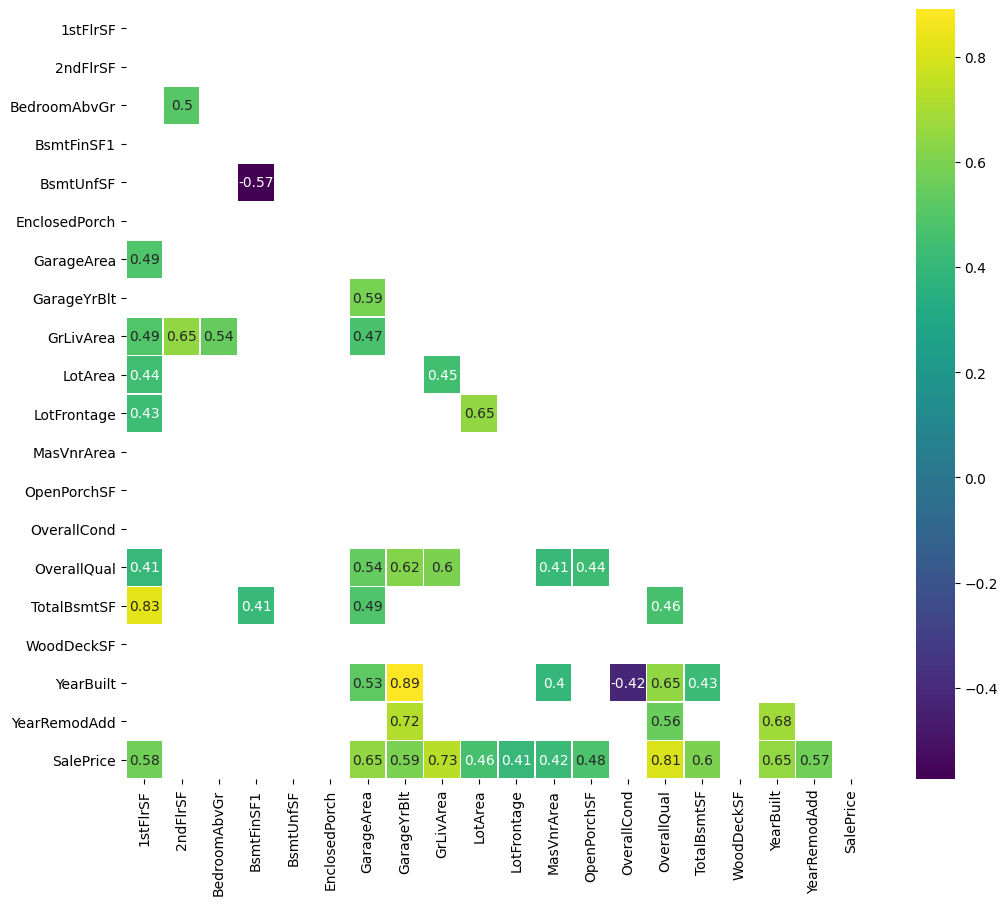



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



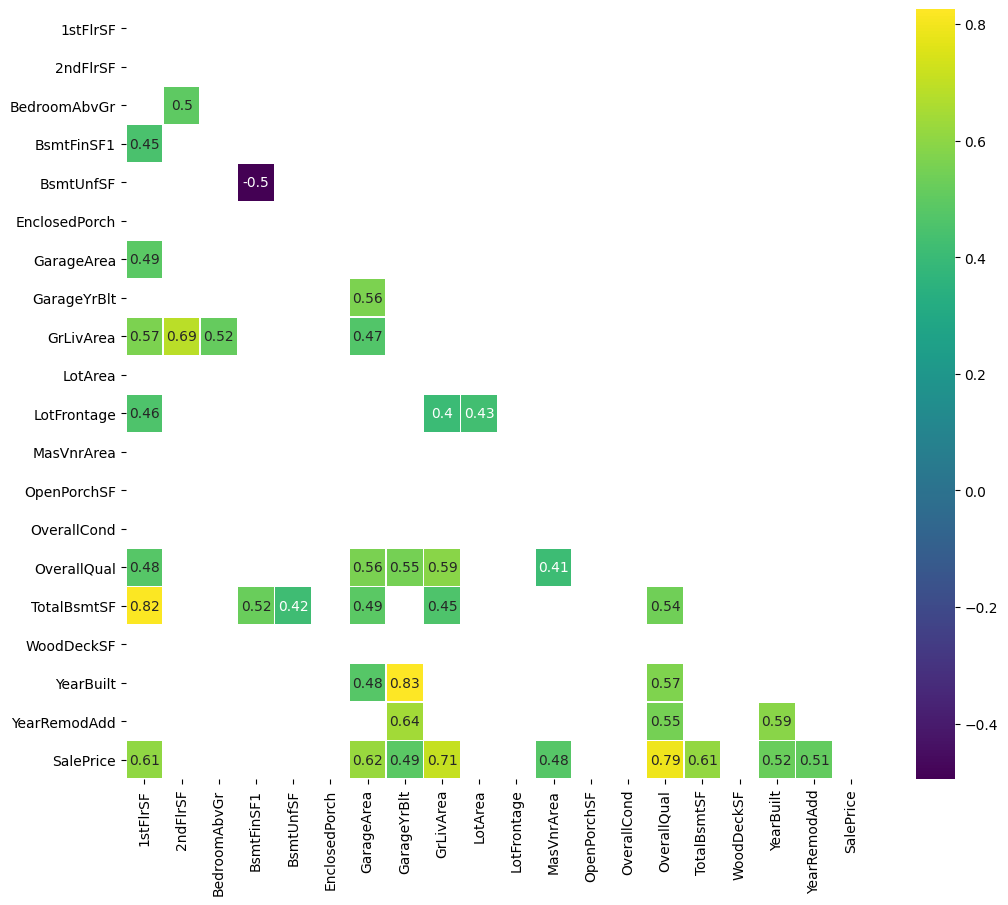



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



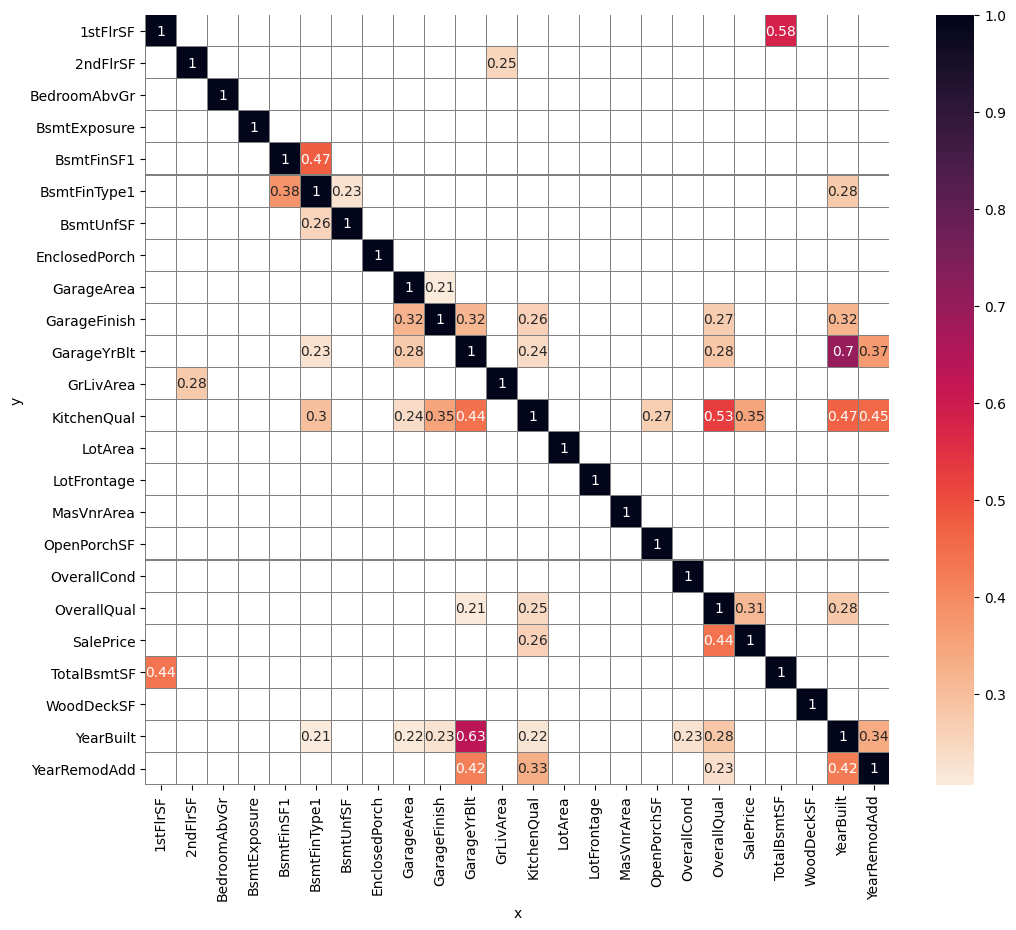

In [9]:
%matplotlib inline
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.4, PPS_Threshold =0.2,
                  figsize=(12,10), font_annot=10)

---

# Data Cleaning

## Assessing Missing Data Levels

The following is a costum function to display missing data levels within a DataFrame.
This excerpt has been extracted from the Code Institute Churnometer Walkthrough Project notebooks.

In [10]:
def EvaluateMissingData(df):
  missing_data_absolute = df.isnull().sum()
  missing_data_percentage = round(missing_data_absolute/len(df)*100 , 2)
  df_missing_data = (pd.DataFrame(
                          data= {"RowsWithMissingData": missing_data_absolute,
                                 "PercentageOfDataset": missing_data_percentage,
                                 "DataType":df.dtypes}
                                  )
                    .sort_values(by=['PercentageOfDataset'],ascending=False)
                    .query("PercentageOfDataset > 0")
                    )

  return df_missing_data

Check missing data level for collected dataset.

In [11]:
EvaluateMissingData(df)


,RowsWithMissingData,PercentageOfDataset,DataType
EnclosedPorch,1324,90.68,float64
WoodDeckSF,1305,89.38,float64
LotFrontage,259,17.74,float64
GarageFinish,162,11.10,object
BsmtFinType1,114,7.81,object
BedroomAbvGr,99,6.78,float64
2ndFlrSF,86,5.89,float64
GarageYrBlt,81,5.55,float64
MasVnrArea,8,0.55,float64


From the result table, we can understand how to proceed with the missing values based on the percentage of missing data.

1. **EnclosedPorch** and **WoodDeckSF**: 
* Since these columns have a very high percentage of missing data (90.68% and 89.38% respectively), can be considered for dropping as they have no significant correlation with the Sales Price, their removal will not greatly impact the model.
2. **LotFrontage**: 
* This column has a missing data percentage of 17.74%. For a numeric column like this, the "MeanMedianImputer" approach can be applied to handle the missing values.
3. **GarageFinish** and **BsmtFinType1**: 
* These columns have missing data percentages of 11.10% and 7.81% respectively. Since they are categorical columns, the "CategoricalVariableImputer" approach can be used. 
4. **BedroomAbvGr**, **2ndFlrSF**, **GarageYrBlt**, and **MasVnrArea**: 
* These columns have relatively low percentages of missing data (ranging from 0.55% to 6.78%). For numeric columns like these, the "MeanMedianImputer" approach can be used.

## Dealing with Missing Data

### Custom functions for Data Cleaning

To initiate the data cleaning process, we add the DataCleaningEffect() costum function from Code Institute's Feature Engine module.
* The purpose of the function is to evaluate the impact of data cleaning when different methods are applied. 
    * For numerical variables,the function assesses the effect of imputing missing values with the mean, median, or an arbitrary number. 
    * For categorical variables, it examines the effect of replacing missing values with 'Missing' or the most frequent category. 
* The function takes three parameters: `df_original`, which represents the original data before cleaning; `df_cleaned`, which represents the cleaned data; and `variables_applied_with_method`, which indicates the variables where a specific cleaning method was applied. 

In [12]:
import seaborn as sns
sns.set(style="whitegrid")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def DataCleaningEffect(df_original,df_cleaned,variables_applied_with_method):

  flag_count=1 # Indicate plot number
  
  # distinguish between numerical and categorical variables
  categorical_variables = df_original.select_dtypes(exclude=['number']).columns 

  # scan over variables, 
    # first on variables that you applied the method
    # if the variable is a numerical plot, a histogram if categorical plot a barplot
  for set_of_variables in [variables_applied_with_method]:
    print("\n=====================================================================================")
    print(f"* Distribution Effect Analysis After Data Cleaning Method in the following variables:")
    print(f"{set_of_variables} \n\n")
  

    for var in set_of_variables:
      if var in categorical_variables:  # it is categorical variable: barplot
        
        df1 = pd.DataFrame({"Type":"Original","Value":df_original[var]})
        df2 = pd.DataFrame({"Type":"Cleaned","Value":df_cleaned[var]})
        dfAux = pd.concat([df1, df2], axis=0)
        fig , axes = plt.subplots(figsize=(15, 5))
        sns.countplot(hue='Type', data=dfAux, x="Value",palette=['#432371',"#FAAE7B"])
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.xticks(rotation=90)
        plt.legend() 

      else: # it is numerical variable: histogram

        fig , axes = plt.subplots(figsize=(10, 5))
        sns.histplot(data=df_original, x=var, color="#432371", label='Original', kde=True,element="step", ax=axes)
        sns.histplot(data=df_cleaned, x=var, color="#FAAE7B", label='Cleaned', kde=True,element="step", ax=axes)
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.legend() 

      plt.show()
      flag_count+= 1

## Data Cleaning Summary

We will proceed with the data cleaning process by implementing the following steps:

1. Dropping features: `['EnclosedPorch', 'WoodDeckSF']`
2. MeanMedianImpute to the following variables: `['LotFrontage', 'BedroomAbvGr', '2ndFlrSF', 'GarageYrBlt', 'MasVnrArea']`
3. CategoricalVariableImputer for the variables `['GarageFinish', 'BsmtFinType1']`

### DropFeatures

In [13]:
from feature_engine.selection import DropFeatures

variables_method = ['EnclosedPorch', 'WoodDeckSF']

imputer = DropFeatures(features_to_drop=variables_method)
imputer.fit_transform(df)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,548,RFn,2003.0,...,8450,65.0,196.0,61,5,7,856,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,460,RFn,1976.0,...,9600,80.0,0.0,0,8,6,1262,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,608,RFn,2001.0,...,11250,68.0,162.0,42,5,7,920,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,642,Unf,1998.0,...,9550,60.0,0.0,35,5,7,756,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,836,RFn,2000.0,...,14260,84.0,350.0,84,5,8,1145,2000,2000,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,953,694.0,3.0,No,0,Unf,953,460,RFn,1999.0,...,7917,62.0,0.0,40,5,6,953,1999,2000,175000
1456,2073,0.0,NaN,No,790,ALQ,589,500,Unf,1978.0,...,13175,85.0,119.0,0,6,6,1542,1978,1988,210000
1457,1188,1152.0,4.0,No,275,GLQ,877,252,RFn,1941.0,...,9042,66.0,0.0,60,9,7,1152,1941,2006,266500
1458,1078,0.0,2.0,Mn,49,NaN,0,240,Unf,1950.0,...,9717,68.0,0.0,0,6,5,1078,1950,1996,142125


### MeanMedianImputer


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['LotFrontage', 'BedroomAbvGr', '2ndFlrSF', 'GarageYrBlt', 'MasVnrArea'] 




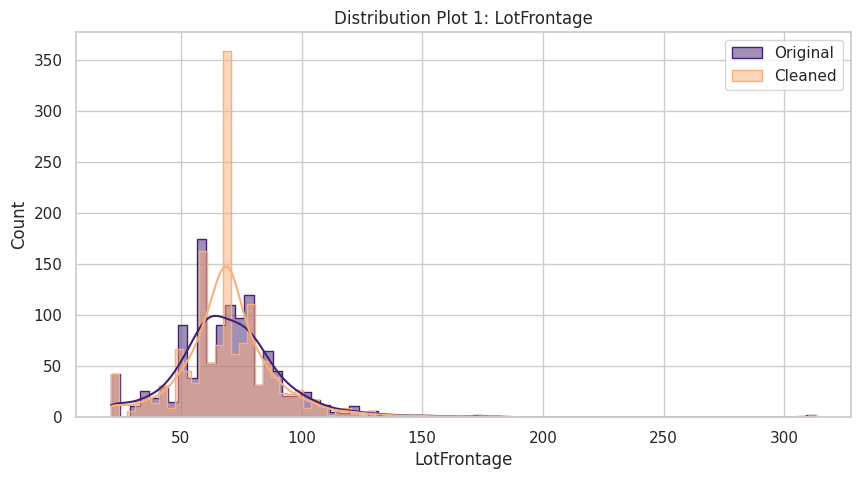

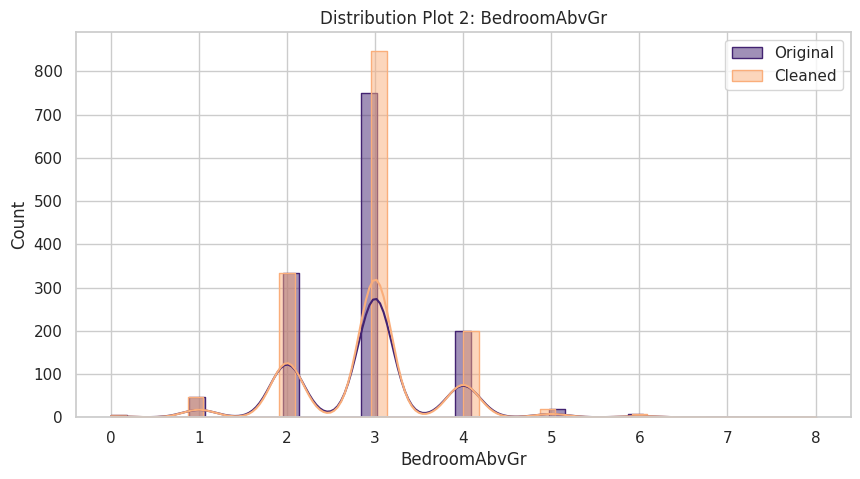

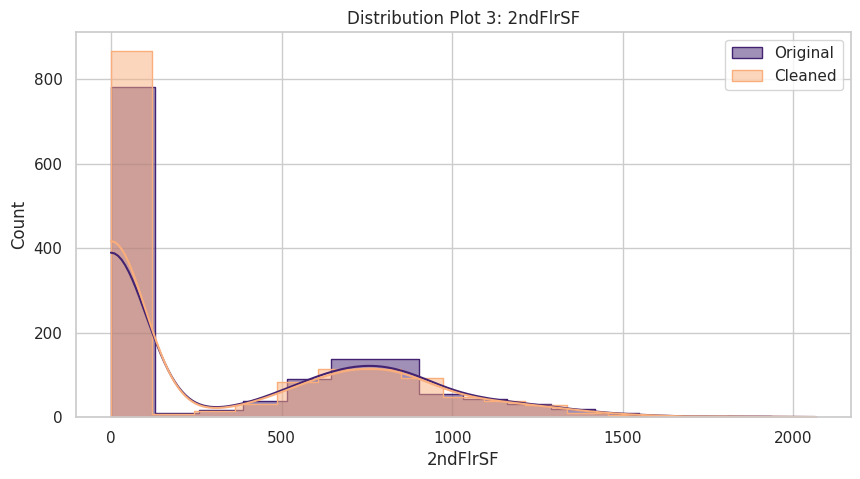

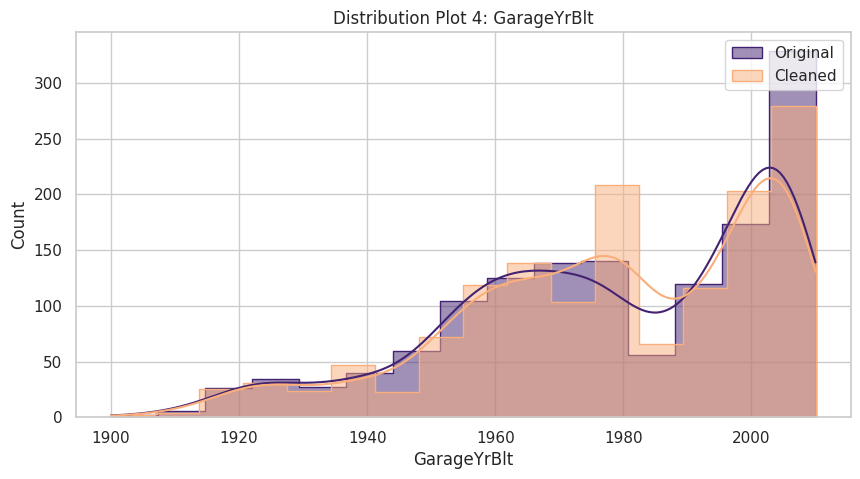

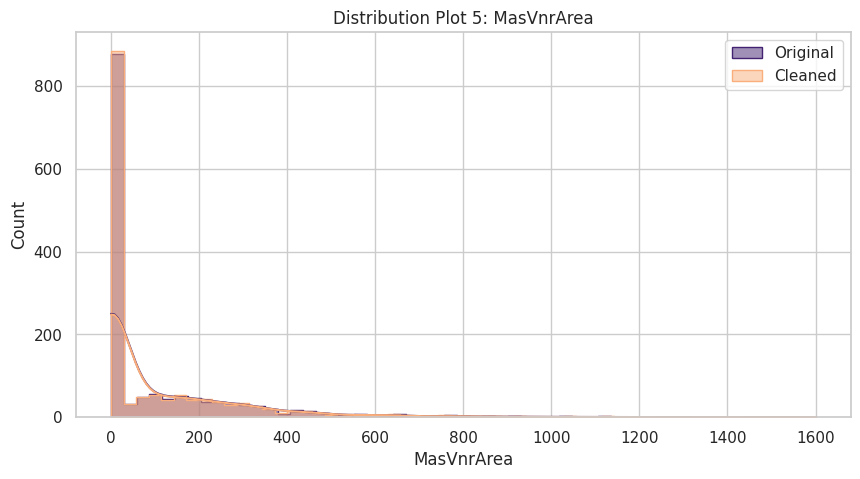

In [14]:
from feature_engine.imputation import MeanMedianImputer

variables_method = ['LotFrontage', 'BedroomAbvGr', '2ndFlrSF', 'GarageYrBlt', 'MasVnrArea']

imputer = MeanMedianImputer(imputation_method='median', variables=variables_method)

df_method = imputer.fit_transform(df)

DataCleaningEffect(df_original=df,
                  df_cleaned=df_method,
                  variables_applied_with_method=variables_method)


### CategoricalImputer


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['GarageFinish', 'BsmtFinType1'] 




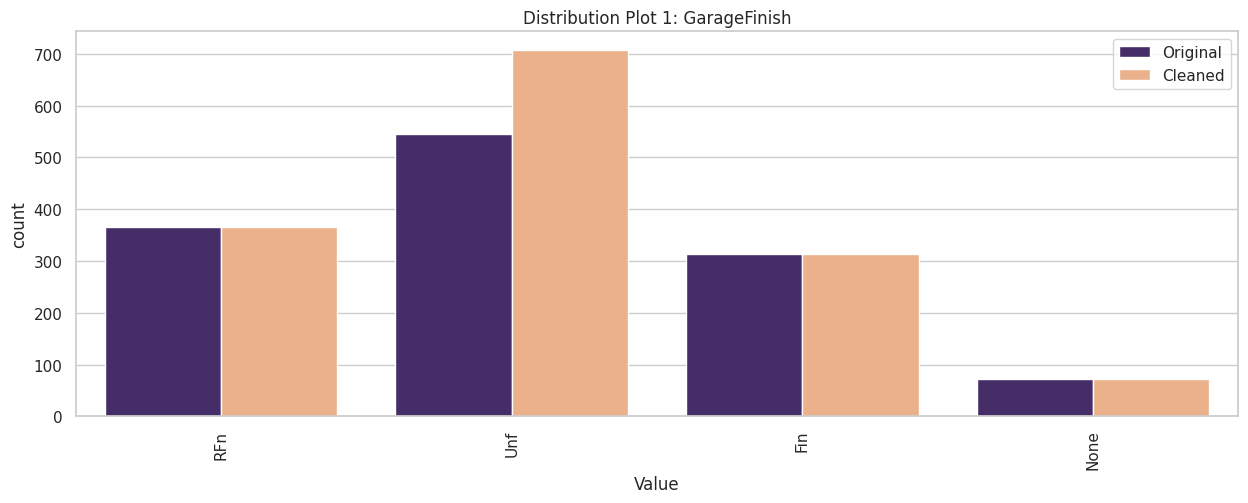

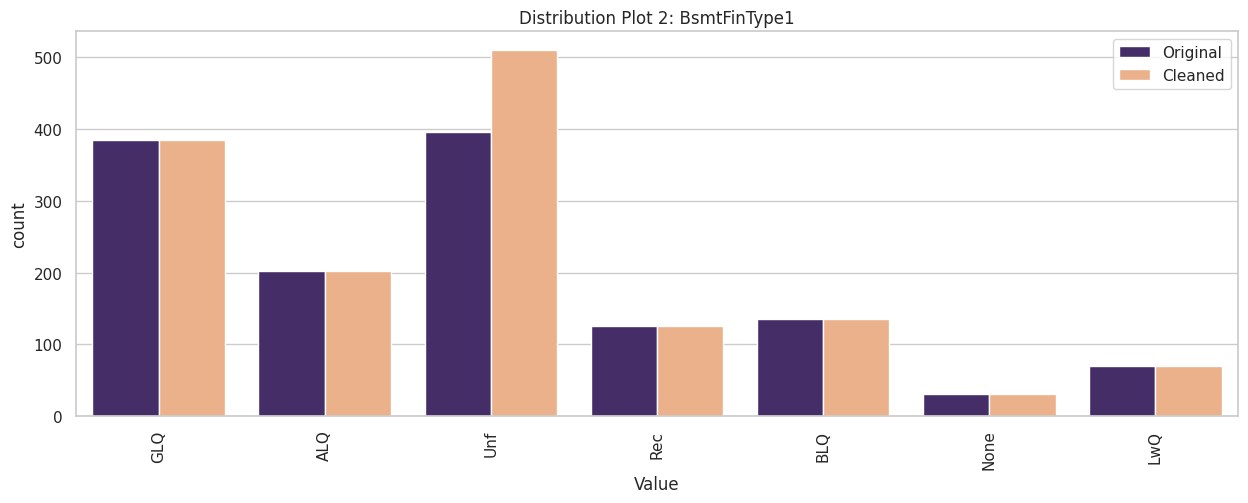

In [15]:
from feature_engine.imputation import CategoricalImputer

variables_method = ['GarageFinish', 'BsmtFinType1']

imputer = CategoricalImputer(imputation_method='missing', fill_value='Unf', variables=variables_method)

df_method = imputer.fit_transform(df)

DataCleaningEffect(df_original=df,
                  df_cleaned=df_method,
                  variables_applied_with_method=variables_method)

## Split Train and Test Set

In [16]:
from sklearn.model_selection import train_test_split
TrainSet, TestSet, _, __ = train_test_split(
                                        df,
                                        df['SalePrice'],
                                        test_size=0.2,
                                        random_state=0)

print(f"TrainSet shape: {TrainSet.shape} \nTestSet shape: {TestSet.shape}")

TrainSet shape: (1168, 24) 
TestSet shape: (292, 24)


## Apply the Transformation to the Data

### DropFeatures

In [17]:
variables_method = ['EnclosedPorch', 'WoodDeckSF']
imputer = DropFeatures(features_to_drop=variables_method)
imputer.fit(TrainSet)

TrainSet, TestSet = imputer.transform(TrainSet) , imputer.transform(TestSet)

### MeanMedianImputer

In [18]:
variables_method = ['LotFrontage', 'BedroomAbvGr', '2ndFlrSF', 'GarageYrBlt', 'MasVnrArea']
imputer = MeanMedianImputer(imputation_method='median', variables=variables_method)

imputer.fit_transform(TrainSet)

TrainSet, TestSet = imputer.transform(TrainSet) , imputer.transform(TestSet)

### CategoricalImputer

In [19]:
variables_method = ['GarageFinish', 'BsmtFinType1']
imputer = CategoricalImputer(imputation_method='missing', fill_value='Unf', variables=variables_method)

imputer.fit_transform(TrainSet)

TrainSet, TestSet = imputer.transform(TrainSet) , imputer.transform(TestSet)

## Checking Missing Data

In [20]:
df_missing_data = EvaluateMissingData(TrainSet)
print(f"* There are {df_missing_data.shape[0]} variables with missing data \n")
df_missing_data

* There are 0 variables with missing data 



,RowsWithMissingData,PercentageOfDataset,DataType


In [21]:
df_missing_data = EvaluateMissingData(TestSet)
print(f"* There are {df_missing_data.shape[0]} variables with missing data \n")
df_missing_data

* There are 0 variables with missing data 



,RowsWithMissingData,PercentageOfDataset,DataType


# Push files to Repo

In [22]:
import os
try:
  os.makedirs(name='outputs/datasets/cleaned') # create outputs/datasets/cleaned folder
except Exception as e:
  print(e)

# TrainSet

In [23]:
TrainSet.to_csv("outputs/datasets/cleaned/train_set_cleaned.csv", index=False)

# TestSet

In [25]:
TestSet.to_csv("outputs/datasets/cleaned/test_set_cleaned.csv", index=False)